In [1]:
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import os

# load environment variables from .env file for project
dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

#data_directory = os.getenv("data_directory")
data_directory = "/netappdata/ssi_tdjg/data/ssi/preprocessing/05-final"
feature_directory = os.path.join(data_directory, "features")
data_directory, feature_directory

('/netappdata/ssi_tdjg/data/ssi/preprocessing/05-final',
 '/netappdata/ssi_tdjg/data/ssi/preprocessing/05-final/features')

In [2]:
lidl_df = pd.read_parquet(os.path.join(data_directory, "ssi_lidl_revenue.parquet"), engine="pyarrow")
#lidl_df.rename(columns={"bg_number": "supermarket_id", "ean_name": "receipt_text"}, inplace=True)
lidl_df.receipt_text = lidl_df.receipt_text.str.replace('[^0-9a-zA-Z.,-/ ]', '', regex=True).str.lstrip().str.rstrip().str.lower()
lidl_df.head()

,store_id,year_month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,...,amount,year,month,product_id,coicop_level_1,coicop_level_2,coicop_level_3,coicop_level_4,count,receipt_text
0,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3185518,92775.0,...,1.0,2018,01,3267751534058161652,01,011,0111,01111,56,sushi rijst
1,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183385,22571.0,...,2565.0,2018,01,-3564191818957410183,01,011,0111,01111,56,italiaanse risotto gesorteerd
2,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183851,51009.0,...,121651.0,2018,01,-4665729291832571192,01,011,0111,01111,56,rijst zilvervlies 1kg
3,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183852,51010.0,...,66080.0,2018,01,-9042628376296108328,01,011,0111,01111,56,rijst wit 1kg
4,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183945,55571.0,...,67783.0,2018,01,-6693002140100701691,01,011,0111,01111,56,traditionele basmati rijst xxl


In [38]:
lidl_df.year_month.min(), lidl_df.year_month.max(), len(lidl_df)
                                            

('201801', '202308', 413280)

In [3]:
lidl_df.columns

Index(['store_id', 'year_month', 'coicop_number', 'coicop_name', 'isba_number',
       'isba_name', 'esba_number', 'esba_name', 'rep_id', 'ean_number',
       'ean_name', 'revenue', 'amount', 'year', 'month', 'product_id',
       'coicop_level_1', 'coicop_level_2', 'coicop_level_3', 'coicop_level_4',
       'count', 'receipt_text'],
      dtype='object')

In [4]:
os.listdir(data_directory)

['ssi_plus_revenue.parquet',
 'ssi_jumbo_revenue.parquet',
 'ssi_ah_revenue.parquet',
 'ssi_lidl_revenue.parquet']

In [5]:
plus_df = pd.read_parquet(os.path.join(data_directory, "ssi_plus_revenue.parquet"), engine="pyarrow")
plus_df.receipt_text = plus_df.receipt_text.str.replace('[^0-9a-zA-Z.,-/ ]', '', regex=True).str.lstrip().str.rstrip().str.lower()
plus_df.head()

,start_date,end_date,store_id,year_month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,...,amount,year,month,product_id,coicop_level_1,coicop_level_2,coicop_level_3,coicop_level_4,count,receipt_text
0,2022-03-01,2022-03-31,901027,202203,011110,Rijst,11110701,Rijst,3711,Witte rijst,...,4781.0,2022,03,-5090812329662242176,01,011,0111,01111,298,snelkookrijst buil
1,2022-03-01,2022-03-31,901027,202203,011110,Rijst,11110701,Rijst,3711,Witte rijst,...,17145.0,2022,03,3243999266577649169,01,011,0111,01111,298,witte rijst
2,2022-03-01,2022-03-31,901027,202203,011110,Rijst,11110701,Rijst,3711,Witte rijst,...,24363.0,2022,03,-2599113672145145167,01,011,0111,01111,298,witte rijst
3,2022-03-01,2022-03-31,901027,202203,011110,Rijst,11110701,Rijst,3711,Witte rijst,...,2051.0,2022,03,4452068391797043079,01,011,0111,01111,298,1 minuut witte rijst
4,2022-03-01,2022-03-31,901027,202203,011110,Rijst,11110701,Rijst,3711,Witte rijst,...,1864.0,2022,03,676954586733214782,01,011,0111,01111,298,1 minuut zilv.rijst


In [44]:
ah_df = pd.read_parquet(os.path.join(data_directory, "ssi_ah_revenue.parquet"), engine="pyarrow")
ah_df.receipt_text = ah_df.receipt_text.str.replace('[^0-9a-zA-Z.,-/ ]', '', regex=True).str.lstrip().str.rstrip().str.lower()
ah_df.head()

,store_id,year_month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,...,month,product_id,coicop_level_1,coicop_level_2,coicop_level_3,coicop_level_4,count,receipt_text,isba_description,start_date
0,470111,202301,011110,Rijst,0111102201_011118001,Rijst,182200,basis rijst,58650694,5011157996592,...,01,4013017697068537924,01,011,0111,01111,238,tilda rice,Rijst,2023-01-01
1,470111,202301,011110,Rijst,0111102201_011118001,Rijst,182200,basis rijst,4923416,8718781600624,...,01,6123949729820683062,01,011,0111,01111,238,lassie built,Rijst,2023-01-01
2,470111,202301,011110,Rijst,0111102201_011118001,Rijst,182200,basis rijst,14857942,8718781601133,...,01,-3771322195463238841,01,011,0111,01111,238,vliesrijst,Rijst,2023-01-01
3,470111,202301,011110,Rijst,0111102201_011118001,Rijst,182200,basis rijst,58650708,8718781601706,...,01,-2379360330508535683,01,011,0111,01111,238,lassie rijst,Rijst,2023-01-01
4,470111,202301,011110,Rijst,0111102201_011118001,Rijst,182200,basis rijst,59230031,8718781601768,...,01,5616022400798920137,01,011,0111,01111,238,lassie rijst,Rijst,2023-01-01


In [66]:
len(jumbo_df)

1297653

In [47]:
len(ah_df)

945023

In [51]:
ah_df.year_month.min(), ah_df.year_month.max()

('202301', '202312')

In [56]:
ah_df.receipt_text.sample(10)

737862    royal tomate
606985           kiosk
707210    ah koekenpan
535075     honig basis
652262     bavaria 0.0
757818     trappe isid
360532     stickerboek
70988        wenskaart
19682            kiosk
94611     gourmet doos
Name: receipt_text, dtype: object

In [58]:
ah_df.receipt_text.isna().sum()

0

In [65]:
jumbo_df = pd.read_parquet(os.path.join(data_directory, "ssi_jumbo_revenue.parquet"), engine="pyarrow")
jumbo_df.receipt_text = jumbo_df.receipt_text.str.replace('[^0-9a-zA-Z.,-/ ]', '', regex=True).str.lstrip().str.rstrip().str.lower()
jumbo_df.head()

,start_date,end_date,store_id,year_month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,...,ean_name,revenue,amount,year,month,coicop_level_1,coicop_level_2,coicop_level_3,coicop_level_4,receipt_text
0,2023-05-01,2023-05-31,906172,202305,011710,Verse of gekoelde groenten behalve aardappele...,011710009_011748002,Overige verse groenten,1628,3D_GRNTN ONBW,...,PREI,1489.079956,1384.0,2023,05,01,011,0117,01171,prei
1,2023-05-01,2023-05-31,906172,202305,011710,Verse of gekoelde groenten behalve aardappele...,011710009_011748002,Overige verse groenten,1628,3D_GRNTN ONBW,...,PREI,1489.079956,1384.0,2023,05,01,011,0117,01171,vleestomaten
2,2023-05-01,2023-05-31,906172,202305,011710,Verse of gekoelde groenten behalve aardappele...,011710009_011748002,Overige verse groenten,1628,3D_GRNTN ONBW,...,PREI,1489.079956,1384.0,2023,05,01,011,0117,01171,prei
3,2023-05-01,2023-05-31,906172,202305,011710,Verse of gekoelde groenten behalve aardappele...,011710009_011748002,Overige verse groenten,1628,3D_GRNTN ONBW,...,ADJUMA ROOD,142.000000,125.0,2023,05,01,011,0117,01171,adjuma rood
4,2023-05-01,2023-05-31,906172,202305,011710,Verse of gekoelde groenten behalve aardappele...,011710009_011748002,Overige verse groenten,1628,3D_GRNTN ONBW,...,ADJUMA ROOD,142.000000,125.0,2023,05,01,011,0117,01171,adjuma rood


In [74]:
jumbo_df.columns

Index(['start_date', 'end_date', 'store_id', 'year_month', 'coicop_number',
       'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name',
       'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount', 'year',
       'month', 'coicop_level_1', 'coicop_level_2', 'coicop_level_3',
       'coicop_level_4', 'receipt_text'],
      dtype='object')

In [75]:
len(jumbo_df)

1297653

In [72]:
unique_eans_lidl = set(lidl_df.ean_number.values.tolist())
unique_eans_plus = set(plus_df.ean_number.values.tolist())
unique_eans_ah = set(ah_df.ean_number.values.tolist())
unique_eans_jumbo = set(jumbo_df.ean_number.values.tolist())

In [73]:
len(unique_eans_lidl), len(unique_eans_plus), len(unique_eans_ah), len(unique_eans_jumbo), len(unique_eans_lidl) + len(unique_eans_plus)

(40659, 118460, 41060, 1538, 159119)

In [64]:
plus_lidl = len(unique_eans_plus.intersection(unique_eans_lidl)) / (len(unique_eans_plus) + len(unique_eans_lidl)) * 100
plus_ah = len(unique_eans_plus.intersection(unique_eans_ah)) / (len(unique_eans_plus) + len(unique_eans_ah)) * 100
ah_lidl = len(unique_eans_lidl.intersection(unique_eans_ah)) / (len(unique_eans_lidl) + len(unique_eans_ah)) * 100
plus_lidl, plus_ah, ah_lidl

(0.0829567807741376, 10.524699097291876, 0.0)

In [48]:
same_eans = unique_eans_plus.intersection(unique_eans_lidl)
len(same_eans)

132

In [49]:
unique_texts_lidl = set(lidl_df.receipt_text)
unique_texts_plus = set(plus_df.receipt_text)
unique_texts_ah = set(ah_df.receipt_text)

len(unique_texts_lidl), len(unique_texts_plus), len(unique_texts_ah)

(31178, 161846, 13976)

In [50]:
ah_df.receipt_text.nunique()

13976

In [67]:
jumbo_df.receipt_text.nunique()

16793

In [68]:
jumbo_df.receipt_text.isna().sum()

0

In [71]:
jumbo_df.receipt_text.sample(10)

591650         cl grof volkoren
1191006    slagersboterhamworst
1214497                 rib eye
232396        grouster rolletje
246802             papieren tas
86149      actie witte asperges
894748     vloer tijger bruin h
585145          mammoet pompoen
777037         amb gerookt spek
1088818    wit tijger vloer hal
Name: receipt_text, dtype: object

In [76]:
jumbo_df.ean_number.sample(10)

462579     2259430000000
732127     2190010000000
1278912    2259060000000
887106     2229570000000
516251     2249070000000
607794     2299440000000
970185     2259860000000
652716     2229350000000
446642     2199080000000
21746      2229370000000
Name: ean_number, dtype: object

In [77]:
jumbo_df.ean_number.nunique()

1538

In [40]:
# only 1771 texts, even after cleaning the receipt texts

same_texts = unique_texts_lidl.intersection(unique_texts_plus)
len(same_texts)

1771

In [11]:
(len(unique_texts_lidl) + len(unique_texts_plus))

193024

In [12]:
# overlap only 0.92 %, very small!

len(same_texts) / (len(unique_texts_lidl) + len(unique_texts_plus)) * 100

0.9175024867374004

In [61]:
len(unique_texts_lidl.intersection(unique_texts_ah)) / (len(unique_texts_lidl) + len(unique_texts_ah)) * 100

1.036453027417283

In [62]:
len(unique_texts_plus.intersection(unique_texts_ah)) / (len(unique_texts_plus) + len(unique_texts_ah)) * 100

1.3826483602734583

In [13]:
unique_text_splits_lidl = set([word for receipt_text in unique_texts_lidl for word in receipt_text.split()])
unique_text_splits_plus = set([word for receipt_text in unique_texts_plus for word in receipt_text.split()])
len(unique_text_splits_lidl), len(unique_text_splits_plus)

(21656, 63101)

In [41]:
#unique_text_splits_lidl.intersection(unique_text_splits_plus)

In [42]:
len(unique_text_splits_lidl.intersection(unique_text_splits_plus))

8098

In [43]:
# If we split up the texts and look at the overlap of the separate words in both lidl and plus, overlap is only 9.6 %
len(unique_text_splits_lidl.intersection(unique_text_splits_plus)) / (len(unique_text_splits_lidl) + len(unique_text_splits_plus)) * 100

9.554373090128248

In [59]:
unique_to_lidl = unique_text_splits_lidl.difference(unique_text_splits_plus)
#unique_to_lidl

In [60]:
unique_to_plus = unique_text_splits_plus.difference(unique_text_splits_lidl)
#unique_to_plus

In [19]:
def overlap(words_left: set, words_right_left) -> float:
    return len(words_left.intersection(words_right_left)) / (len(words_left) + len(words_right_left)) * 100

def process_plus(word: str) -> str:
    #if 'eieren' not in word:
    #    word = word.replace('eiere', 'eieren')
    #if word.endswith('sal'):
    #    word = word.replace('sal', 'salade')
    return word.lower()

def process_words_plus(words: set) -> set:
    return set([process_plus(word) for word in words])
    
overlap_raw = overlap(unique_text_splits_lidl, unique_text_splits_plus)
overlap_processed = overlap(process_words_plus(unique_text_splits_lidl), process_words_plus(unique_text_splits_plus))

overlap_raw, overlap_processed, overlap_processed > overlap_raw

(9.554373090128248, 9.554373090128248, False)

In [20]:
plus_df.columns

Index(['start_date', 'end_date', 'store_id', 'year_month', 'coicop_number',
       'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name',
       'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount', 'year',
       'month', 'product_id', 'coicop_level_1', 'coicop_level_2',
       'coicop_level_3', 'coicop_level_4', 'count', 'receipt_text'],
      dtype='object')

In [21]:
plus_product_descriptions = set(plus_df.ean_name)
len(plus_product_descriptions)

233073

In [22]:
[word for i, word in enumerate(plus_product_descriptions) if i < 10]

['BACARD Bacardi Coco 70 CL',
 'OLD AMST Plakken 190 GR',
 'PLUS Procureurlap naturel 1 KG',
 'LOKAAL Wrap Chicken 1 ST',
 '## SPARERIBS PIRI',
 'TULBAND rozijn 1 ST',
 '## FRAMBOOS & CRANBE',
 'Uienpoeder kookmutsjes 50 GR',
 '* 2 stuks 2 ST',
 '## KIP SALADE RUTTEN']

In [23]:
plus_split_descriptions = set([word for description in plus_product_descriptions for word in description.split()])

In [24]:
overlap(unique_texts_lidl, plus_product_descriptions), overlap(unique_text_splits_lidl, plus_split_descriptions)

(0.0, 5.191900066186881)

<Axes: ylabel='Frequency'>

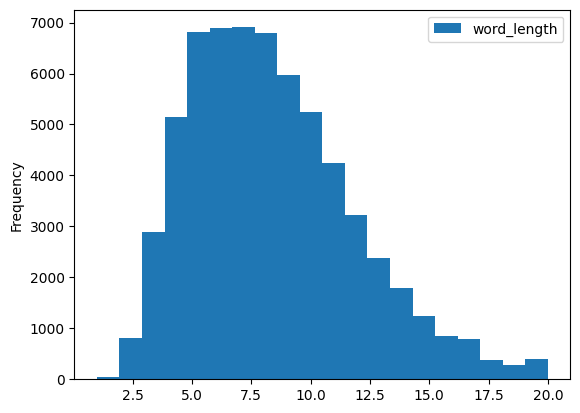

In [25]:
plus_length_df = pd.DataFrame({
    "word_length": [len(word) for word in unique_text_splits_plus]
})
plus_length_df.plot.hist(column="word_length", bins=plus_length_df.word_length.nunique())

<Axes: ylabel='Frequency'>

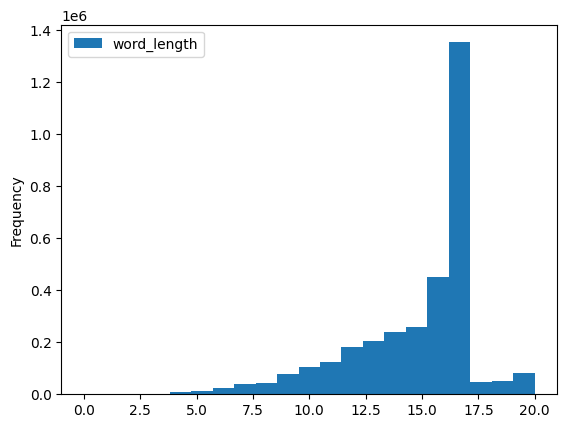

In [26]:
plus_receipt_length_df = pd.DataFrame({
    "word_length": [len(word) for word in plus_df.receipt_text]
})
plus_receipt_length_df.plot.hist(column="word_length", bins=plus_receipt_length_df.word_length.nunique())

<Axes: ylabel='Frequency'>

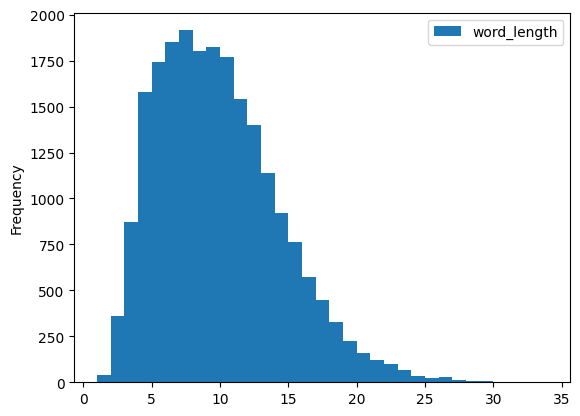

In [27]:
lidl_length_df = pd.DataFrame({
    "word_length": [len(word) for word in unique_text_splits_lidl]
})
lidl_length_df.plot.hist(column="word_length", bins=lidl_length_df.word_length.nunique())

<Axes: ylabel='Frequency'>

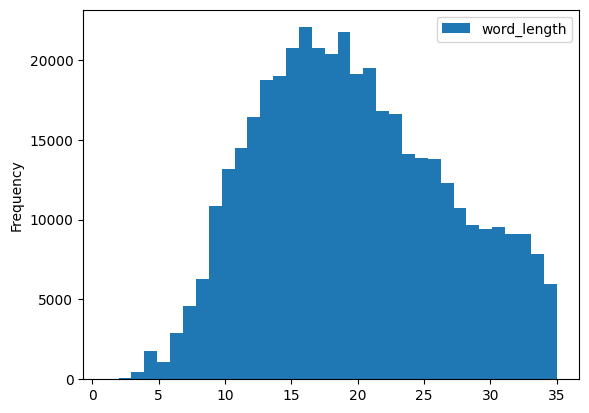

In [28]:
lidl_receipt_length_df = pd.DataFrame({
    "word_length": [len(word) for word in lidl_df.receipt_text]
})
lidl_receipt_length_df.plot.hist(column="word_length", bins=lidl_receipt_length_df.word_length.nunique())

In [29]:
from typing import List
import numpy as np

def word_length_histograms(supermarket_names: List[str], supermarket_text_series: List[pd.Series]) -> pd.DataFrame:
    text_length_per_supermarket = dict()
    unique_word_lengths = set()
    for supermarket_name, supermarket_texts in zip(supermarket_names, supermarket_text_series):    
        all_word_lengths = [len(word) for word in supermarket_texts]
        unique_word_lengths = unique_word_lengths.union(set(all_word_lengths))
        text_length_per_supermarket[supermarket_name] = all_word_lengths
    
    min_word_length = min(unique_word_lengths)
    max_word_length = max(unique_word_lengths)
    
    word_length_histogram_df = pd.DataFrame(index=sorted(unique_word_lengths))
    for supermarket_name, word_lengths in  text_length_per_supermarket.items():  
        hist, bin_edges = np.histogram(word_lengths, bins=len(unique_word_lengths))
        word_length_histogram_df[f"{supermarket_name}_word_lengths"] = hist
    
    return word_length_histogram_df
        
receipt_length_hist = word_length_histograms(["lidl", "plus"], [lidl_df.receipt_text, plus_df.receipt_text])
receipt_length_hist.head()

,lidl_word_lengths,plus_word_lengths
0,1,2
1,110,21
2,448,0
3,1793,84
4,1079,0


<Axes: >

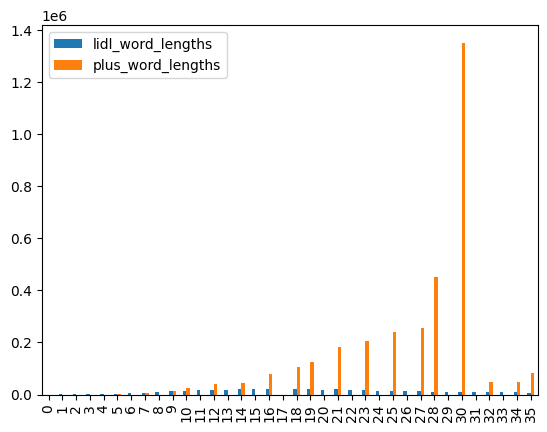

In [30]:
# Fix plot to show two overlapping bar plots.
receipt_length_hist.plot.bar()

## Overlap per COICOP

In [31]:
coicop_lidl = lidl_df.coicop_level_1.unique()
coicop_lidl

array(['01', '12', '02', '05', '09', '03', '06', '99'], dtype=object)

In [32]:
coicop_plus = plus_df.coicop_level_1.unique()
coicop_plus

array(['01', '12', '02', '03', '05', '06', '08', '09', '99'], dtype=object)

In [33]:
coicop_both = set(coicop_lidl).intersection(set(coicop_plus))
coicop_both

{'01', '02', '03', '05', '06', '09', '12', '99'}

In [34]:
coicop_overlap_dict = dict()
for coicop in coicop_both:
    lidl_texts = set(lidl_df[lidl_df.coicop_level_1 == coicop].receipt_text)
    plus_texts = set(plus_df[plus_df.coicop_level_1 == coicop].receipt_text)
    coicop_overlap_dict[coicop] = overlap(lidl_texts, plus_texts)
coicop_overlap_dict

{'06': 0.4551096400496483,
 '05': 0.4806591897459373,
 '01': 0.9187174851492454,
 '99': 0.596210749458994,
 '12': 0.19603038470963,
 '02': 0.10862186014935506,
 '03': 0.3295978905735003,
 '09': 1.0526315789473684}

In [35]:
coicop_words_overlap_dict = dict()
for coicop in coicop_both:
    lidl_texts = set([word for receipt_text in lidl_df[lidl_df.coicop_level_1 == coicop].receipt_text for word in receipt_text.split()])
    plus_texts = set([word for receipt_text in plus_df[plus_df.coicop_level_1 == coicop].receipt_text for word in receipt_text.split()])
    coicop_words_overlap_dict[coicop] = overlap(lidl_texts, plus_texts)
coicop_words_overlap_dict

{'06': 2.4814976055724856,
 '05': 7.41302972802024,
 '01': 9.480018932990737,
 '99': 7.49025974025974,
 '12': 9.857142857142858,
 '02': 5.846831486217676,
 '03': 4.92874109263658,
 '09': 7.638589533580481}